In [1]:
from torch.autograd import grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

%matplotlib inline

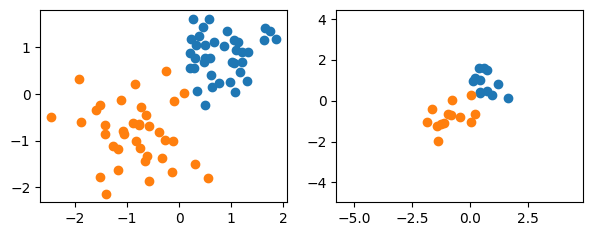

In [2]:
##########################
### DATASET
##########################

data = np.genfromtxt('toydata.txt', delimiter='\t')
x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

np.random.seed(123)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

In [21]:
class LogisticRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias).view(-1) # net input
        probas = self._sigmoid(linear)
        return probas
        
    def backward(self, x, y, probas):  
        grad_loss_wrt_z = probas.view(-1) - y
        grad_loss_wrt_w = torch.mm(x.t(), grad_loss_wrt_z.view(-1, 1))
        grad_loss_wrt_b = torch.sum(grad_loss_wrt_z)
        return grad_loss_wrt_w, grad_loss_wrt_b
            
    def predict_labels(self, x):
        probas = self.forward(x)
        labels = torch.where(probas >= .5, 1, 0) # threshold function
        return labels    
            
    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy
    
    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba.view(-1, 1)))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba.view(-1, 1)))
        return tmp1 - tmp2
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        epoch_cost = []
        for e in range(num_epochs):
            
            #### Compute outputs ####
            probas = self.forward(x)
            
            #### Compute gradients ####
            grad_w, grad_b = self.backward(x, y, probas)

            #### Update weights ####
            self.weights -= learning_rate * grad_w
            self.bias -= learning_rate * grad_b
            
            #### Logging ####
            cost = self._logit_cost(y, self.forward(x)) / x.size(0)
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % cost)
            epoch_cost.append(cost)
        return epoch_cost

In [22]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

model1 = LogisticRegression1(num_features=2)
epoch_cost = model1.train(X_train_tensor, y_train_tensor, num_epochs=30, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % model1.weights)
print('  Bias: %s' % model1.bias)

Epoch: 001 | Train ACC: 0.973 | Cost: 0.055
Epoch: 002 | Train ACC: 0.973 | Cost: 0.053
Epoch: 003 | Train ACC: 0.973 | Cost: 0.051
Epoch: 004 | Train ACC: 0.973 | Cost: 0.049
Epoch: 005 | Train ACC: 0.973 | Cost: 0.048
Epoch: 006 | Train ACC: 0.973 | Cost: 0.047
Epoch: 007 | Train ACC: 0.973 | Cost: 0.046
Epoch: 008 | Train ACC: 0.973 | Cost: 0.045
Epoch: 009 | Train ACC: 0.973 | Cost: 0.044
Epoch: 010 | Train ACC: 0.987 | Cost: 0.043
Epoch: 011 | Train ACC: 0.987 | Cost: 0.042
Epoch: 012 | Train ACC: 0.987 | Cost: 0.041
Epoch: 013 | Train ACC: 0.987 | Cost: 0.041
Epoch: 014 | Train ACC: 0.987 | Cost: 0.040
Epoch: 015 | Train ACC: 0.987 | Cost: 0.039
Epoch: 016 | Train ACC: 0.987 | Cost: 0.039
Epoch: 017 | Train ACC: 1.000 | Cost: 0.038
Epoch: 018 | Train ACC: 1.000 | Cost: 0.038
Epoch: 019 | Train ACC: 1.000 | Cost: 0.037
Epoch: 020 | Train ACC: 1.000 | Cost: 0.036
Epoch: 021 | Train ACC: 1.000 | Cost: 0.036
Epoch: 022 | Train ACC: 1.000 | Cost: 0.036
Epoch: 023 | Train ACC: 1.000 | 

In [4]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)

    def forward(self, x):
        netinputs = self.linear(x)
        activations = torch.sigmoid(netinputs)
        return activations.view(-1)

In [5]:
device = "cpu"
torch.manual_seed(123)
model = LogisticRegression(num_features=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [6]:
def comp_accuracy(label_var, pred_probas):
    pred_labels = torch.where((pred_probas > 0.5), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)

np.random.seed(123)
for epoch in range(30):
    out = model(X_train_tensor)
    
    loss = F.binary_cross_entropy(out, y_train_tensor.squeeze(), reduction='sum')

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
         
    pred_probas = model.forward(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor.squeeze()))

print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)

Epoch: 001 | Train ACC: 0.973 | Cost: 0.058
Epoch: 002 | Train ACC: 0.973 | Cost: 0.054
Epoch: 003 | Train ACC: 0.973 | Cost: 0.051
Epoch: 004 | Train ACC: 0.973 | Cost: 0.049
Epoch: 005 | Train ACC: 0.973 | Cost: 0.047
Epoch: 006 | Train ACC: 0.973 | Cost: 0.046
Epoch: 007 | Train ACC: 0.973 | Cost: 0.044
Epoch: 008 | Train ACC: 0.973 | Cost: 0.043
Epoch: 009 | Train ACC: 0.973 | Cost: 0.042
Epoch: 010 | Train ACC: 0.973 | Cost: 0.042
Epoch: 011 | Train ACC: 0.987 | Cost: 0.041
Epoch: 012 | Train ACC: 0.987 | Cost: 0.040
Epoch: 013 | Train ACC: 0.987 | Cost: 0.040
Epoch: 014 | Train ACC: 0.987 | Cost: 0.039
Epoch: 015 | Train ACC: 0.987 | Cost: 0.038
Epoch: 016 | Train ACC: 0.987 | Cost: 0.038
Epoch: 017 | Train ACC: 0.987 | Cost: 0.037
Epoch: 018 | Train ACC: 1.000 | Cost: 0.037
Epoch: 019 | Train ACC: 1.000 | Cost: 0.036
Epoch: 020 | Train ACC: 1.000 | Cost: 0.036
Epoch: 021 | Train ACC: 1.000 | Cost: 0.035
Epoch: 022 | Train ACC: 1.000 | Cost: 0.035
Epoch: 023 | Train ACC: 1.000 | 